In [1]:
!pip install numpy pandas matplotlib opencv-python scikit-image

You should consider upgrading via the 'c:\users\kedar\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [1]:
import time
import random
import cv2
import os
import math
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.widgets import Cursor
from PIL import Image
import hashlib
from yolo_opencv import detect_object
import pandas as pd

%matplotlib inline

#confuse and diffuse scheme
#date : 2019.6.3 10.56

# def PL_PWLCM(y0,p2,exp32):
#     y1=0
#     if y0<p2:
#         y1 = math.floor(exp32*y0/p2)
#     elif p2<y0 and y0 < exp32/2:
#         y1 = math.floor(exp32*(y0-p2)/(exp32/2 - p2))
#     elif y0 == exp32/2 :
#         y1 = 0
#     else:
#         y1 = PL_PWLCM(exp32-y0, p2, exp32)
#     return y1


def SkewTent(y0,p2,exp32):
    y1=0
    if y0<p2:
        y1 = math.floor(exp32*y0/p2)
    elif y0 == p2 :
        y1 = exp32-1
    elif p2<y0 and y0 < exp32:
        y1 = math.floor(exp32*(exp32-y0)/(exp32 - p2))
    return y1

'''
PWLCM MAP
'''
def SCCS_MAP(y0, p2, exp32):
    y1=0
    if y0<p2:
        y1 = math.floor(exp32*y0/p2)
    elif p2<y0 and y0 < exp32/2:
        y1 = math.floor(exp32*(y0-p2)/(exp32/2 - p2))
    elif y0 == exp32/2 :
        y1 = 0
    else:
        y1 = SCCS_MAP(exp32-y0, p2, exp32)
    return y1

'''
Logistic Map used in CML Map
'''
def PL_Logistic(x0,exp32):
    x1 = math.floor(4*x0*(exp32-x0)/exp32)
    return x1

'''
CML MAP
'''
def CCCS_MAP(x0,exp32, ep=0.5):
    x0 = x0 % 256
    log_x1 = PL_Logistic(x0, exp32)
    x1 = (1-ep) * log_x1 + (ep/2) * log_x1 + log_x1
    return math.floor(x1)

def PL_PWLCM_Logistic(x0,y0,p1,z0,p2):
    exp32 = 4294967296
    y1 = SCCS_MAP(y0,p1,exp32)
    x1 = SkewTent(z0,p2,exp32)
    z1 = CCCS_MAP(x0,exp32)
    temp1 = x1 ^ y1
    r1 = (temp1 + z1) % exp32
    return x1,y1,z1,r1

def PWLCM_Init(x0,y0,p1,p2,exp32,n):
    x1 = x0
    y1 = y0
    for i in range(n):
        x1 = SCCS_MAP(x1,p1,exp32)
        y1 = SCCS_MAP(y1,p2,exp32)
    return x1,y1

def Logistic_Init(x0,n,exp32):
    x1 = x0
    for i in range(n):
        x1 = CCCS_MAP(x1,exp32)
    return x1

def InitPRNG(x0,y0,p1,z0,p2,n):
    exp32 = 4294967296
    for i in range(n):
        y1,z1 = PWLCM_Init(y0,z0,p1,p2,exp32,n)
        x1 = SCCS_MAP(x0,n,exp32)
    return x1,y1,z1

# get the second column
def takeSecond(elem):
    return elem[1]
#key generation v2 output : PRNGlist, 32-Bit sorted sorting index 
def getPRNG(a,b,c,x0,y0,p1,z0,p2):
    iLen = math.ceil(a*b*c)
    SortLen = (a)*(b)*c # if the a and c are not the interal multiple of 2, discard the last row and column 
    #print('the prng interation rounds is :',iLen)
    #print("the sort list's len is :", SortLen)
    SortList = list();
    ValueList = np.zeros(a*b*c, dtype = int, order = 'C')
    time_start=time.time()
    for iNum in range(iLen):
        #print('total:', iLen, '+++++++Now:',iNum)
        x0,y0,z0,res = PL_PWLCM_Logistic(x0,y0,p1,z0,p2)
        if iNum < SortLen:
            SortList.append([iNum,res])
        if (iNum+1)*4 <= a*b*c:
            ValueList[iNum*4] = (res >> 24) & 0xff
            ValueList[iNum*4+1] = (res >> 16) & 0x00ff
            ValueList[iNum*4+2] = (res >> 8) & 0x0000ff
            ValueList[iNum*4+3] = (res >> 0) & 0x000000ff
        else:
            tail = a * b * c % 4
            shiftUnit = [0xff,0x00ff,0x0000ff,0x000000ff]
            for i in range(tail):
                if iNum * 4 + i < len(ValueList):
                    ValueList[iNum*4+i] = (res >> 24-i*8) & shiftUnit[i]
    time_end=time.time()
    #print('PRNG Generation time cost:',time_end-time_start,'s')
    pd.DataFrame(np.array(SortList), columns=["Index", "Res"]).to_csv("SortList.csv", index=False)
    SortList.sort(key=takeSecond)
    pd.DataFrame(np.array(SortList), columns=["Index", "Res"]).to_csv("SortList-sorted.csv", index=False)
#     print(SortList)
    if c == 1: #gray
        return SortList,ValueList.reshape(a,b),x0,y0,z0
    else:
        return SortList,ValueList.reshape(a,b,c),x0,y0,z0

# Initialization
# def getParas(key):
#     p2 = key & 0x7fffffff
#     z0 = (key>>31) & 0x7fffffff
#     p1 = (key>>62) & 0x7fffffff
#     y0 = (key>>93) & 0x7fffffff
#     x0 = (key>>124) & 0xffffffff
    
#     x0,y0,z0 = InitPRNG(x0,y0,p1,z0,p2,20)    
#     return x0,y0,p1,z0,p2

def generate_key(key):
    k1 = hashlib.sha512(key)
    k1 = bin(int.from_bytes(k1.digest(), "big"))[2:494]
    k2 = hashlib.sha512(k1.encode("utf-8"))
    k2 = bin(int.from_bytes(k2.digest(), "big"))[2:494]
    return k2

def getKeys(key):
    k1 = key[:80]
    k2 = key[160:160+80]
    k3 = key[240:240+36]
    k4 = key[276: 276+36]
    k5 = key[312:348]
    k6 = key[348:384]
    k7 = key[384:420]
    k8 = key[420:456]
    k9 = key[456:492]
    k11 = bin(int(k1[:40], 2) ^ int(k2[:40], 2))
    k12 = bin(int(k1[40:], 2) ^ int(k2[40:], 2))
    k13 = bin(int(k3, 2) ^ int(k4, 2))
    k14 = bin(int(k5, 2) ^ int(k6, 2))
    k15 = bin(int(k7, 2) ^ int(k8, 2) ^ int(k9, 2))
    
#     x1 = int(k11, 2) / 2**40
#     x2 = int(k12, 2) / 2**40
#     x3 = int(k13, 2) / 2**35
#     x4 = int(k14, 2) / 2**35
    x5 = int(k15, 2) / 2**35
    x6 = 0.87 + ((int(k13, 2) ^ int(k14, 2)) / 2**35) % 0.13
    x7 = (int(k13, 2) ^ int(k15, 2)) / 2**35
    x8 = 0.87 + ((int(k14, 2) ^ int(k15, 2)) / 2**35) % 0.13
    x9 = (int(k13, 2) ^ int(k14, 2) ^ int(k15, 2)) / 2**35
    
#     x1 = x1 ^ x9
#     x2 = x2 ^ x8
#     x3 = x3 ^ x7
#     x4 = x4 ^ x6
#     x5 = x5 ^ (x6 ^ x7 ^ x8 ^ x9)
       
    
    return list(map(lambda x: x % 1, [x5, x6, x7, x8, x9]))

def getParas(key):
    key = generate_key(key)
    xs = getKeys(key)
    val = 2 ** 32
    x0 = xs[0] * val
    y0 = xs[1] * val
    z0 = xs[2] * val
    p1 = xs[3] * val
    p2 = xs[4] * val
    
    x0,y0,z0 = InitPRNG(x0,y0,p1,z0,p2,20)    
    return x0,y0,p1,z0,p2

def Enc(a,SortKey,ValueKey,scale,diffRound=1):
#     print(SortKey, SortKey.shape)
    w,h = a.shape
    k = SortKey
    #confusion
    c =  np.zeros((w,h), dtype=int)
    c = a.copy().flatten()
#     print(len(k))
    for i in range(len(k)):
        temp = c[i]
        c[i] = c[k[i]]
        c[k[i]] = temp
        
    plt.imshow(c.reshape((w, h//3, 3)), cmap='gray')
    b = np.zeros((w,h), dtype=int)
    b = c.copy().reshape((w,h))
    for iwhole in range(diffRound):
        #step2.1 diffuse row
        for iRow in range(0,w,1):
#             print(iRow, end="")
            if iRow == 0:
                b[iRow,:] = (b[-1,:] + b[iRow,:] + ValueKey[iRow,:]) % scale
            else:
                b[iRow,:] = (b[iRow-1,:] + b[iRow,:] + ValueKey[iRow,:]) % scale

        #step2.2 diffuse column
        for iCol in range(0,h,1):
            if iCol == 0:
                b[:, iCol] = (b[:, -1] + b[:, iCol] + ValueKey[:, iCol]) % scale
            else:
                b[:, iCol] = (b[:, iCol-1] + b[:, iCol] + ValueKey[:, iCol]) % scale


    return b

def Dec(a,SortKey,ValueKey,scale,diffRound=1):
    w,h = a.shape
    c =  np.zeros((w,h), dtype=int)
    c = a.copy()
    k = SortKey
    
    for iwhole in range(diffRound):
        for iCol in range(h-1,-1,-1):
            if iCol == 0:
                c[:, iCol] = (c[:, iCol] - c[:, -1] - ValueKey[:, iCol]) % scale
            else:
                c[:, iCol] = (c[:, iCol] - c[:, iCol-1] - ValueKey[:, iCol]) % scale
        for iRow in range(w-1,-1,-1):
            if iRow == 0:
                c[iRow,:] = (c[iRow,:] - c[-1,:] - ValueKey[iRow,:])% scale
            else:
                c[iRow,:] = (c[iRow,:] - c[iRow-1,:] - ValueKey[iRow,:])% scale 
    
    b =  np.zeros((w,h), dtype=int)
    b = c.copy().flatten()
    #confusion
    for i in range(len(k)-1, -1, -1):
        temp = b[i]
        b[i] = b[k[i]]
        b[k[i]] = temp
    return b.reshape((w,h))


def DoEnc(img,k=None, round=2):
    n = round # Encryption round
    w,h = img.shape #return row and column
    keys = []
    for i in range(n):
        x0,y0,p1,z0,p2 = getParas(img)
        keys.append((x0, y0, p1, z0, p2))
#         print("Encryption: ", (x0, y0, p1, z0, p2))
        sort,valuekey,x0,y0,z0 = getPRNG(w,h,1,x0,y0,p1,z0,p2)
        arr = np.array(sort)
        sortkey = arr[:,0]
        img = Enc(img,sortkey,valuekey,256,2)
    return img, keys


def DoDec(img,k,round = 2):
    n = round # Encryption round    
    w,h = img.shape #return row and column
    for i in range(n-1,-1,-1):
        x0,y0,p1,z0,p2 = k[i]
#         print("Decryption: ", (x0, y0, p1, z0, p2))
        sort,valuekey,x0,y0,z0 = getPRNG(w,h,1,x0,y0,p1,z0,p2)
        arr = np.array(sort)
        sortkey = arr[:,0]
        img = Dec(img,sortkey,valuekey,256,2)
    return img

In [2]:
def DoColorEnc(img,k=None, round=2):
    n = round # Encryption round
    #step1. initialization
    
    w,h,d = img.shape #return row and column
    img = img.reshape((w,h*d))
#     print(img.shape)
    keys = list()
    for i in range(n):
        x0,y0,p1,z0,p2 = getParas(np.ascontiguousarray(img))
        if k is not None:
            z0 += 1
        keys.append((x0,y0,p1,z0,p2))
        sort,valuekey,x0,y0,z0 = getPRNG(w,h*d,1,x0,y0,p1,z0,p2)
        arr = np.array(sort)
        sortkey = arr[:,0]
        img = Enc(img,sortkey,valuekey,256,2)
    
    img = img.reshape((w,h,d))
    return img, keys

def DoColorDec(img, k, round=2):
    n = round # Encryption round    
    w,h,d = img.shape #return row and column
    img = img.reshape((w,h*d))
    for i in range(n-1,-1,-1):
        x0,y0,p1,z0,p2 = k[i]
        sort,valuekey,x0,y0,z0 = getPRNG(w,h*d,1,x0,y0,p1,z0,p2)
        arr = np.array(sort)
        sortkey = arr[:,0]
        img = Dec(img,sortkey,valuekey,256,2)
    img = img.reshape((w,h,d))
    return img

def ObjectDetectionTest(file, crop=True, draw=False):
    og = cv2.imread(file)
    og = cv2.cvtColor(og, cv2.COLOR_BGR2RGB)
    
    if crop:
        start_det = time.perf_counter()
        img, (x, y) = detect_object(file,draw=draw)
        end_det = time.perf_counter()
        print("Detection Time:", (end_det - start_det))
        if img.size > 0:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            print(img)
            print("No Object Detected!")
            return
    else:
        img = og

#     img = cv2.imread(file)
    print("Image Size:", og.shape)
    print("Detected Shape", img.shape)

    plt.figure(figsize=(20, 18))
    plt.subplot(1, 3, 1)
    plt.imshow(og, cmap="gray")
    plt.title("Original Image")
    
    if crop:
        plt.subplot(1, 3, 2)
        plt.imshow(img, cmap="gray")
        plt.title("Object Detected")
    
    start_enc = time.perf_counter()
    encrypted, keys = DoColorEnc(img, round=1)
    end_enc = time.perf_counter()
    print("Encryption Time:", (end_enc - start_enc))
    
    start_dec = time.perf_counter()
    decrypted = DoColorDec(img, keys, round=1)
    end_dec = time.perf_counter()
    print("Decryption Time:", (end_dec - start_dec))
    
    if crop:
        og[y:y+encrypted.shape[0], x: x+encrypted.shape[1]] = encrypted
    else:
        og = encrypted
    
    plt.subplot(1, 3, 3)
    plt.imshow(og)
    plt.title("Encrypted")
    plt.show()
    
    if crop:
         return (file, og.shape, (end_enc - start_enc), (end_dec - start_enc), (x, y, img.shape[0], img.shape[1]))
    
    return (file, og.shape, (end_enc - start_enc), (end_dec - start_enc))
    
# ObjectDetectionTest("./new/group.jpg")
# ObjectDetectionTest("./new/group.jpg", crop=False)

def ColorDetectionTest(draw=False, to_file=None):
    path = "./test2/"
    arr = []
    for file in os.listdir(path):
        print(path+file)
        _, shape, enctime, dectime, coords = ObjectDetectionTest(path + file, draw=draw)
        _, shape, totalenctime, totaldectime = ObjectDetectionTest(path + file, crop=False)
        arr.append((file, shape, totalenctime, totaldectime, enctime, dectime, coords[0], coords[1], coords[2], coords[3]))
    arr = np.array(arr)
    arr = pd.DataFrame(arr, columns=["File Name", "Image Size", "Total Encryption Time", "Total Decryption Time", "Encryption Time", "Decryption Time", "X", "Y", "Width", "Height"])
    
    print(arr.head())
    if to_file:
        arr.to_csv(to_file, index=False)

# ColorDetectionTest(draw=True)

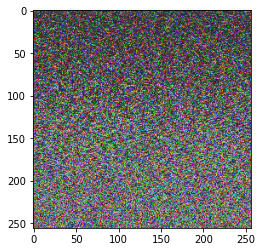

In [44]:
img = np.array(Image.open("./test2/399.png"))
encrypted, keys = DoColorEnc(img, round=1)
decrypted = DoColorDec(encrypted, keys, round=1)
# plt.imshow(decrypted, cmap="gray")
# w, h, d = decrypted.shape
# plt.imshow(decrypted.reshape((w, h*d)), cmap="gray")